In [6]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import os
import cv2
import math
import random

%matplotlib inline 

## Загрузка шаблона карты

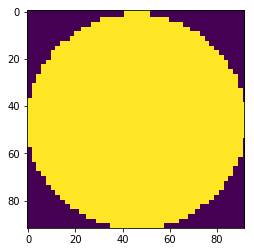

In [252]:
wafer_map = pd.read_pickle('test_wafer_map.pkl')
test = cv2.resize(wafer_map.waferMap, dsize=(92,92), interpolation=cv2.INTER_NEAREST) 

## 2 - паттерн
## 1 - фон
## 0 - область, где нет ничего
test[test == 2] = 1

## проверка
plt.imshow(test);

# Генератор пилообразных прямых 

In [253]:
def sawtooth_line(XC_, YC_, L0_, angle_, line_count, pattern_type, lam_poisson=0.2):
    size = XC_.shape[0]
    df = [None] * size
    
    for n in range(size):   
        # иниицализация параметров прямой
        L0 = L0_[n]
        XC = XC_[n]
        YC = YC_[n]
        angle = angle_[n]
        ## создадим тестовый полигон
        test = cv2.resize(wafer_map.waferMap, dsize=(92,92), interpolation=cv2.INTER_NEAREST) 
        ## 2 - паттерн
        ## 1 - фон
        ## 0 - область, где нет ничего
        test[test == 2] = 1
        COLOR_SCALE = 2

        ## параметры уравнения
        def delta_(x,y):
            return int(math.sqrt(x**2 + y**2))
        delta = np.vectorize(delta_)

        L = L0 - np.sum(delta(XC, YC)[1:])
        N = 200
        x0, y0 = 0, 0

        ## кусочное построение пилообразной прямой 
        for i in range(line_count):
            ## случайное удлинение или укорочение отрезка
            import random
            rand = random.randint(-1,0)
            scale = 0.4
            t = np.linspace(0, L//(line_count + rand*scale), N)

            xc = XC[i]
            yc = YC[i]
            X = np.cos(angle[i]) * t + xc + x0
            Y = np.sin(angle[i]) * t + yc + y0
            X_ = np.around(X)
            Y_ = np.around(Y)

            x_prev, y_prev = x0, y0

            for j in range(X_.shape[0]):
                x = int(X_[j])
                y = int(Y_[j])
                if j == 0:
                    ## первая точка прямой 
                    x_first, y_first = x, y

                try:
                    if test[x,y] == 1:
                        test[x,y] = COLOR_SCALE
                        x0, y0 = x, y
                except IndexError:
                    break


            ## сшивка прямых        
            if i != 0:
                ## уравнение прямой сшивки
                k = (y_prev - y_first) / (x_prev - x_first+1e-06)
                b = y_first - k*x_first
                X = np.linspace(x_prev, x_first, 20)
                Y = k * X + b
                X_ = np.around(X)
                Y_ = np.around(Y)
                for j in range(X_.shape[0]):
                    x = int(X_[j])
                    y = int(Y_[j])
                    try:
                        if test[x,y] == 1:
                            test[x,y] = COLOR_SCALE
                    except IndexError:
                        break

        is_dilate = random.randint(-1,1)
        if is_dilate == 1:
            ## сверткой расширим
            kernel = np.ones((3,3), np.uint8)
            kernel = np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]], dtype=np.uint8)
            test = cv2.dilate(test,kernel,iterations = 3)
            test = cv2.morphologyEx(test, cv2.MORPH_CLOSE, kernel)
            

        noise_img = test.copy()
        mask = np.random.randint(0, 2, size=noise_img.shape).astype(np.bool)
        mask[noise_img == 0] = False
        r = np.random.poisson(lam=lam_poisson, size=noise_img.shape)
        r[r==0] = 1
        r[r>2] = 2
        noise_img[mask] = r[mask]
        
        is_morph_close = random.randint(0,1)
        if is_morph_close == 1:
            ## сверткой расширим
            kernel = np.ones((3,3), np.uint8)
            kernel = np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]], dtype=np.uint8)
            noise_img = cv2.morphologyEx(noise_img, cv2.MORPH_CLOSE, kernel)

        df[n] = [noise_img, pattern_type]
        
    return pd.DataFrame(df, columns=['waferMap', 'failureType'])

# Генерация кривых

## Пилообразные прямые 

In [327]:
%%time

N_POINT = 2000

L0 = np.random.randint(40, 55, size=N_POINT)

XC = np.random.randint(46, 70, size=N_POINT)
delta_xc = np.random.randint(3, 10, size=N_POINT)
np.random.shuffle(delta_xc)
XC = np.vstack((XC, delta_xc))
xc = np.array([[XC[0,i], XC[1,i]] for i in range(XC.shape[1])])

YC = np.random.randint(46, 70, size=N_POINT)
delta_yc = np.random.randint(-8, -5, size=N_POINT)
np.random.shuffle(delta_yc)
YC = np.vstack((YC, delta_yc))
yc = np.array([[YC[0,i], YC[1,i]] for i in range(YC.shape[1])])

angle1 = np.random.randint(-130, -90, size=N_POINT) * np.pi/180
angle2 = np.random.randint(-130, -100, size=N_POINT) * np.pi/180
angle = np.vstack((angle1, angle2))
angle = np.array([[angle[0,i], angle[1,i]] for i in range(angle.shape[1])])

df_scrath_curved = sawtooth_line(xc, yc, L0, angle, pattern_type='Curved-Scratch', line_count=2)
df_scrath_curved.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
waferMap       2000 non-null object
failureType    2000 non-null object
dtypes: object(2)
memory usage: 31.3+ KB
Wall time: 2.87 s


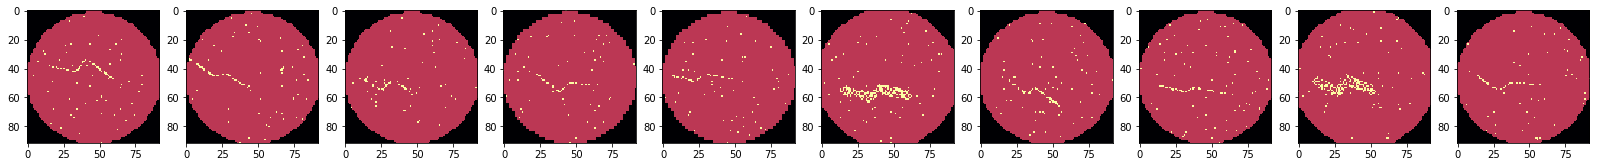

In [47]:
fig, ax = plt.subplots(nrows = 1, ncols = 10, figsize=(28, 20))
ax = ax.ravel(order='C')
for i in range(10, 20):
    ax[i-10].imshow(df_scrath.waferMap[i], cmap='inferno')

plt.show() 

## Прмые линии 

In [326]:
%%time

N_POINT = 2000

L0 = np.random.randint(40, 55, size=N_POINT)

XC = np.random.randint(46, 70, size=N_POINT)
delta_xc = np.zeros(N_POINT)
XC = np.vstack((XC, delta_xc))
xc = np.array([[XC[0,i], XC[1,i]] for i in range(XC.shape[1])])

YC = np.random.randint(46, 70, size=N_POINT)
delta_yc = np.zeros(N_POINT)
YC = np.vstack((YC, delta_yc))
yc = np.array([[YC[0,i], YC[1,i]] for i in range(YC.shape[1])])

angle1 = np.random.randint(-130, -90, size=N_POINT) * np.pi/180
angle = np.vstack((angle1, angle1))
angle = np.array([[angle[0,i], angle[1,i]] for i in range(angle.shape[1])])

df_scrath = sawtooth_line(xc, yc, L0, angle, pattern_type='Scratch', line_count=2)
df_scrath.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
waferMap       2000 non-null object
failureType    2000 non-null object
dtypes: object(2)
memory usage: 31.3+ KB
Wall time: 2.88 s


# Генератор колец 

In [256]:
def create_rings(XC, YC, R_, PHI, N, pattern_type, lam_poisson=1.2):
    size = XC.shape[0]
    df = [None] * size
    
    for n in range(size):
        ## параметры кольца
        phi = np.linspace(PHI[n][0], PHI[n][1], N[n])
        r = np.linspace(R_[n][0], R_[n][1], N[n])
        xc = XC[n]
        yc = YC[n]

        ## синтез сетки
        R, Fi = np.meshgrid(r, phi)
        X = R*(np.cos(Fi)) + xc
        Y = R*(np.sin(Fi)) + yc
        X_ = np.around(X)
        Y_ = np.around(Y)

        ## индексы для полигона
        points = []
        for i in range(X_.shape[0]):
            for j in range(X_.shape[1]):
                x = X_[i,j]
                y = Y_[i,j]
                points.append((x,y))

        ## создадим тестовый полигон
        test = cv2.resize(wafer_map.waferMap, dsize=(92,92), interpolation=cv2.INTER_NEAREST) 
        ## 2 - паттерн
        ## 1 - фон
        ## 0 - область, где нет ничего
        test[test == 2] = 1
        COLOR_SCALE = 2
        
        
        for idx in points:
            i, j = idx
            i = int(round(i))
            j = int(round(j))
            try:
                if test[i,j] == 1:
                    test[i,j] = COLOR_SCALE
            except IndexError:
                break
                
        
        is_dilate = random.randint(-1,1)
        if is_dilate == 1:
            ## сверткой расширим
            kernel = np.ones((3,3), np.uint8)
            kernel = np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]], dtype=np.uint8)
            test = cv2.dilate(test,kernel,iterations = 3)
            test = cv2.morphologyEx(test, cv2.MORPH_CLOSE, kernel)


        ## внесем шум
        noise_img = test.copy()
        mask = np.random.randint(0, 2, size=noise_img.shape).astype(np.bool)
        mask[noise_img == 0] = False
        r = np.random.poisson(lam=lam_poisson, size=noise_img.shape)
        # нормировка на шумы
        # r = np.around(r//np.max(r))
        r[r==0] = 1
        r[r>2] = 2
        noise_img[mask] = r[mask]
        

        ## сверткой расширим
        kernel = np.ones((3,3), np.uint8)
        kernel = np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]], dtype=np.uint8)
        noise_img = cv2.morphologyEx(noise_img, cv2.MORPH_CLOSE, kernel)
        noise_img = cv2.erode(noise_img,kernel,iterations = 1)
        
        df[n] = [noise_img, pattern_type]
        
    return pd.DataFrame(df, columns=['waferMap', 'failureType'])


## Rings

In [300]:
%%time

N_POINTS = 2000

PHI1 = np.random.uniform(0, 120, size=N_POINTS) * np.pi/180
PHI2 = np.random.uniform(250, 360, size=N_POINTS) * np.pi/180
PHI = np.vstack((PHI1, PHI2))
PHI = np.array([[PHI[0,i], PHI[1,i]] for i in range(PHI.shape[1])])

r1 = np.random.randint(18, 20, size=N_POINTS)
r2 = np.random.randint(20, 25, size=N_POINTS)
r = np.vstack((r1, r2))
r = np.array([[r[0,i], r[1,i]] for i in range(r.shape[1])])

XC = np.random.randint(30, 50 , size=N_POINTS)
YC = np.random.randint(30, 50, size=N_POINTS)

## интесивность
N = np.random.randint(200, 210, size=N_POINTS)

df_rings = create_rings(XC, YC, r, PHI, N, pattern_type='Ring')
df_rings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
waferMap       2000 non-null object
failureType    2000 non-null object
dtypes: object(2)
memory usage: 31.3+ KB
Wall time: 6min 18s


## Loc 

In [301]:
%%time

N_POINTS = 2000

PHI1 = np.random.uniform(300, 310, size=N_POINTS) * np.pi/180
PHI2 = np.random.uniform(340, 370, size=N_POINTS) * np.pi/180
PHI = np.vstack((PHI1, PHI2))
PHI = np.array([[PHI[0,i], PHI[1,i]] for i in range(PHI.shape[1])])

r1 = np.random.randint(20, 23, size=N_POINTS)
r2 = np.random.randint(30, 33, size=N_POINTS)
r = np.vstack((r1, r2))
r = np.array([[r[0,i], r[1,i]] for i in range(r.shape[1])])

XC = np.random.randint(25, 65 , size=N_POINTS)
YC = np.random.randint(25, 65, size=N_POINTS)

## интесивность
N = np.random.randint(200, 210, size=N_POINTS)

df_loc = create_rings(XC, YC, r, PHI, N, pattern_type='Loc')
df_loc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
waferMap       2000 non-null object
failureType    2000 non-null object
dtypes: object(2)
memory usage: 31.3+ KB
Wall time: 6min 20s


## Center 

In [302]:
%%time

N_POINTS = 2000

PHI1 = np.random.uniform(0, 10, size=N_POINTS) * np.pi/180
PHI2 = np.random.uniform(45, 80, size=N_POINTS) * np.pi/180
PHI = np.vstack((PHI1, PHI2))
PHI = np.array([[PHI[0,i], PHI[1,i]] for i in range(PHI.shape[1])])

r1 = np.random.randint(0, 1, size=N_POINTS)
r2 = np.random.randint(15, 22, size=N_POINTS)
r = np.vstack((r1, r2))
r = np.array([[r[0,i], r[1,i]] for i in range(r.shape[1])])

XC = np.random.randint(42, 48, size=N_POINTS)
YC = np.random.randint(42, 48, size=N_POINTS)

df_center = create_rings(XC, YC, r, PHI, N, pattern_type='Center')
df_center.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
waferMap       2000 non-null object
failureType    2000 non-null object
dtypes: object(2)
memory usage: 31.3+ KB
Wall time: 6min 11s


## Random sky

In [260]:
%%time

N_POINTS = 2000

PHI1 = np.random.uniform(70, 80, size=N_POINTS) * np.pi/180
PHI2 = np.random.uniform(84, 112, size=N_POINTS) * np.pi/180
PHI = np.vstack((PHI1, PHI2))
PHI = np.array([[PHI[0,i], PHI[1,i]] for i in range(PHI.shape[1])])

r1 = np.random.randint(0, 2, size=N_POINTS)
r2 = np.random.randint(10, 17, size=N_POINTS)
r = np.vstack((r1, r2))
r = np.array([[r[0,i], r[1,i]] for i in range(r.shape[1])])

XC = np.random.randint(25, 65, size=N_POINTS)
YC = np.random.randint(25, 65, size=N_POINTS)

## интесивность
N = np.random.randint(200, 210, size=N_POINTS)

df_sky = create_rings(XC, YC, r, PHI, N, pattern_type='Sky')
df_sky.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
waferMap       2000 non-null object
failureType    2000 non-null object
dtypes: object(2)
memory usage: 31.3+ KB
Wall time: 6min 10s


## Edge-Ring 

In [303]:
%%time

N_POINTS = 2000

PHI1 = np.random.uniform(0, 90, size=N_POINTS) * np.pi/180
PHI2 = np.random.uniform(210, 360, size=N_POINTS) * np.pi/180
PHI = np.vstack((PHI1, PHI2))
PHI = np.array([[PHI[0,i], PHI[1,i]] for i in range(PHI.shape[1])])

r1 = np.random.randint(42, 43, size=N_POINTS)
r2 = np.random.randint(45, 46, size=N_POINTS)
r = np.vstack((r1, r2))
r = np.array([[r[0,i], r[1,i]] for i in range(r.shape[1])])

XC = np.random.randint(44, 45 , size=N_POINTS)
YC = np.random.randint(44, 45, size=N_POINTS)

## интесивность
N = np.random.randint(200, 210, size=N_POINTS)

df_edge_ring = create_rings(XC, YC, r, PHI, N, pattern_type='Edge-Ring')
df_edge_ring.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
waferMap       2000 non-null object
failureType    2000 non-null object
dtypes: object(2)
memory usage: 31.3+ KB
Wall time: 6min 11s


## Edge-Loc 

In [304]:
%%time

N_POINTS = 500

## 1 quadrant
PHI1_1 = np.random.uniform(0, 30, size=N_POINTS) * np.pi/180
PHI2_1 = np.random.uniform(60, 120, size=N_POINTS) * np.pi/180

PHI = np.vstack((PHI1_4, PHI2_4))
PHI = np.array([[PHI[0,i], PHI[1,i]] for i in range(PHI.shape[1])])

r1 = np.random.randint(37, 42, size=N_POINTS)
r2 = np.random.randint(45, 46, size=N_POINTS)
r = np.vstack((r1, r2))
r = np.array([[r[0,i], r[1,i]] for i in range(r.shape[1])])

XC = np.random.randint(44, 45 , size=N_POINTS)
YC = np.random.randint(44, 45, size=N_POINTS)

## интесивность
N = np.random.randint(200, 210, size=N_POINTS)

df_edge_loc1 = create_rings(XC, YC, r, PHI, N, pattern_type='Edge-Loc')
df_edge_loc1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 2 columns):
waferMap       500 non-null object
failureType    500 non-null object
dtypes: object(2)
memory usage: 7.9+ KB
Wall time: 1min 32s


In [305]:
%%time

N_POINTS = 500

## 2 quandrant
PHI1_2 = np.random.uniform(90, 120, size=N_POINTS) * np.pi/180
PHI2_2 = np.random.uniform(150, 210, size=N_POINTS) * np.pi/180

PHI = np.vstack((PHI1_4, PHI2_4))
PHI = np.array([[PHI[0,i], PHI[1,i]] for i in range(PHI.shape[1])])

r1 = np.random.randint(37, 42, size=N_POINTS)
r2 = np.random.randint(45, 46, size=N_POINTS)
r = np.vstack((r1, r2))
r = np.array([[r[0,i], r[1,i]] for i in range(r.shape[1])])

XC = np.random.randint(44, 45 , size=N_POINTS)
YC = np.random.randint(44, 45, size=N_POINTS)

## интесивность
N = np.random.randint(200, 210, size=N_POINTS)

df_edge_loc2 = create_rings(XC, YC, r, PHI, N, pattern_type='Edge-Loc')
df_edge_loc2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 2 columns):
waferMap       500 non-null object
failureType    500 non-null object
dtypes: object(2)
memory usage: 7.9+ KB
Wall time: 1min 33s


In [306]:
%%time

N_POINTS = 500

## 3 quandrant
PHI1_3 = np.random.uniform(170, 180, size=N_POINTS) * np.pi/180
PHI2_3 = np.random.uniform(240, 300, size=N_POINTS) * np.pi/180

PHI = np.vstack((PHI1_4, PHI2_4))
PHI = np.array([[PHI[0,i], PHI[1,i]] for i in range(PHI.shape[1])])

r1 = np.random.randint(37, 42, size=N_POINTS)
r2 = np.random.randint(45, 46, size=N_POINTS)
r = np.vstack((r1, r2))
r = np.array([[r[0,i], r[1,i]] for i in range(r.shape[1])])

XC = np.random.randint(44, 45 , size=N_POINTS)
YC = np.random.randint(44, 45, size=N_POINTS)

## интесивность
N = np.random.randint(200, 210, size=N_POINTS)

df_edge_loc3 = create_rings(XC, YC, r, PHI, N, pattern_type='Edge-Loc')
df_edge_loc3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 2 columns):
waferMap       500 non-null object
failureType    500 non-null object
dtypes: object(2)
memory usage: 7.9+ KB
Wall time: 1min 32s


In [307]:
%%time

N_POINTS = 500

## 4 quandrant
PHI1_4 = np.random.uniform(250, 270, size=N_POINTS) * np.pi/180
PHI2_4 = np.random.uniform(280, 390, size=N_POINTS) * np.pi/180

PHI = np.vstack((PHI1_4, PHI2_4))
PHI = np.array([[PHI[0,i], PHI[1,i]] for i in range(PHI.shape[1])])

r1 = np.random.randint(37, 42, size=N_POINTS)
r2 = np.random.randint(45, 46, size=N_POINTS)
r = np.vstack((r1, r2))
r = np.array([[r[0,i], r[1,i]] for i in range(r.shape[1])])

XC = np.random.randint(44, 45 , size=N_POINTS)
YC = np.random.randint(44, 45, size=N_POINTS)

## интесивность
N = np.random.randint(200, 210, size=N_POINTS)

df_edge_loc4 = create_rings(XC, YC, r, PHI, N, pattern_type='Edge-Loc')
df_edge_loc4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 2 columns):
waferMap       500 non-null object
failureType    500 non-null object
dtypes: object(2)
memory usage: 7.9+ KB
Wall time: 1min 33s


In [308]:
df_edge_loc = pd.concat([df_edge_loc1, df_edge_loc2,
                        df_edge_loc3, df_edge_loc4], sort=False)

## Near-full

In [316]:
def create_near_full(N, pattern_type, lam_poisson=1.2):
    df = [None] * N
    for n in range(N):
        ## создадим тестовый полигон
        test = cv2.resize(wafer_map.waferMap, dsize=(92,92), interpolation=cv2.INTER_NEAREST) 
        ## 2 - паттерн
        ## 1 - фон
        ## 0 - область, где нет ничего
        test[test == 2] = 1
        COLOR_SCALE = 2

        ## внесем шум
        noise_img = test.copy()
        mask = np.random.randint(0, 2, size=noise_img.shape).astype(np.bool)
        mask[noise_img == 0] = False
        r = np.random.poisson(lam=lam_poisson, size=noise_img.shape)
        # нормировка на шумы
        # r = np.around(r//np.max(r))
        r[r==0] = 1
        r[r==1] = 2
        r[r>2] = 1
        noise_img[mask] = r[mask]
        

        ## сверткой расширим
        kernel = np.ones((3,3), np.uint8)
        kernel = np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]], dtype=np.uint8)
        noise_img = cv2.morphologyEx(noise_img, cv2.MORPH_CLOSE, kernel)
        noise_img = cv2.erode(noise_img,kernel,iterations = 1)

        df[n] = [noise_img, pattern_type]
        
    return pd.DataFrame(df, columns=['waferMap', 'failureType'])

In [317]:
df_near_full = create_near_full(2000, pattern_type='Near-Full', lam_poisson=0.2)
df_near_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
waferMap       2000 non-null object
failureType    2000 non-null object
dtypes: object(2)
memory usage: 31.3+ KB


## Random

In [318]:
def create_random(N, pattern_type, lam_poisson=1.2):
    df = [None] * N
    for n in range(N):
        ## создадим тестовый полигон
        test = cv2.resize(wafer_map.waferMap, dsize=(92,92), interpolation=cv2.INTER_NEAREST) 
        ## 2 - паттерн
        ## 1 - фон
        ## 0 - область, где нет ничего
        test[test == 2] = 1
        COLOR_SCALE = 2

        ## внесем шум
        noise_img = test.copy()
        mask = np.random.randint(0, 2, size=noise_img.shape).astype(np.bool)
        mask[noise_img == 0] = False
        r = np.random.poisson(lam=lam_poisson, size=noise_img.shape)
        # нормировка на шумы
        # r = np.around(r//np.max(r))
        r[r==0] = 1
        r[r>2] = 2
        noise_img[mask] = r[mask]
        

        ## сверткой расширим
        kernel = np.ones((3,3), np.uint8)
        kernel = np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]], dtype=np.uint8)
        noise_img = cv2.morphologyEx(noise_img, cv2.MORPH_CLOSE, kernel)
        noise_img = cv2.erode(noise_img,kernel,iterations = 1)

        df[n] = [noise_img, pattern_type]
        
    return pd.DataFrame(df, columns=['waferMap', 'failureType'])

In [319]:
df_random = create_random(2000, pattern_type='Random', lam_poisson=0.8)
df_random.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
waferMap       2000 non-null object
failureType    2000 non-null object
dtypes: object(2)
memory usage: 31.3+ KB


In [328]:
df = pd.concat([df_center, df_rings,
               df_edge_loc, df_edge_ring,
               df_loc, df_random, 
                df_scrath, df_near_full,
               df_scrath_curved], sort=False)

mapping_type={'Center':0,'Ring':1,'Edge-Loc':2,
              'Edge-Ring':3,'Loc':4,'Random':5,
              'Scratch':6, 'Near-Full':7, 'Curved-Scratch':8 }

df['failureNum'] = df.failureType
df = df.replace({'failureNum':mapping_type})
type(df.failureNum.values[1])

numpy.int64

In [329]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18000 entries, 0 to 1999
Data columns (total 3 columns):
waferMap       18000 non-null object
failureType    18000 non-null object
failureNum     18000 non-null int64
dtypes: int64(1), object(2)
memory usage: 562.5+ KB


Loc
4


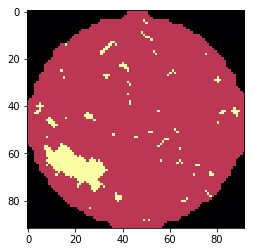

In [324]:
df.to_pickle('output/syntesis_df')

n = 9556
plt.imshow(df.waferMap.values[n],cmap='inferno')
print(df.failureType.values[n])
print(df.failureNum.values[n])

In [315]:
df_test = pd.read_pickle('output/syntesis_df')

Edge-Ring


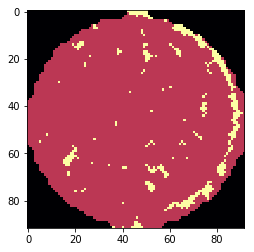

In [277]:
n = 4531
plt.imshow(df_test.waferMap.values[n],cmap='inferno')
print(df_test.failureType.values[n])